**FIT3183 Malicious AI & Dark Side Security**
# Lab 1: Adversarial Machine Learning I (Solution)

*This is the Colab Notebook for the Solution of [this assignment](https://colab.research.google.com/drive/1kQXpFpdoLktfuN8qLzgAJG9Tk26AuDSW?usp=sharing).*

In this lab, we are looking at 4 simple methods to generate adversarial examples with explanation on how they works and detailed instruction for you to actually implement it.

There are 2 tasks:
* Implement black-box attack methods: **Semantic Attack** and **Noise Attack**
* Implement white-box attack methods: **FGSM Attack** and **FGVM Attack**

👉 ***Copy this Colab notebook to your Drive***, read the instruction and fill the missing code in the functions `xxx_attack` and `test_xxx_attack`. After that, run those cells and see if you can successfully fool the deep learning model! You can also run the test with more images.

*Note: If you are new to Google Colab and Pytorch: please read this [Pre-lab Activities](https://drive.google.com/file/d/1aBOkxvGxkOeZlZxYQy0xiEzdEwU-C1DX/view?usp=sharing) first.*

<small>*Prepared by [Linh Vu](mailto:linh.vu@monash.edu) (Lab Tutor) Aug 2020.*

### Helper functions

Here are some helper fuctions for image loading, preprocessing, classification, transformation and visualization.

* `load_and_preprocess(path)`: Load image, convert to a tensor and normalize it. 
> *About Normalization*: ResNet model of PyTorch uses pre-trained weights from Google and they expect inputs with pixel values in between -1 to 1. So the inputs must be normalized with below given mean and standard deviation (for the sake of uniformity): `MEAN = [0.485, 0.456, 0.406]`,
`STD = [0.229, 0.224, 0.225]`. 
* `classify(img)`: One call to classify an image, from image, image url or file path.
* `visualize(x, x_adv, perturb=False)`: Display the clean image and the adversarial image side by side with the predicted labels.

* `NET`: ResNet model with pretrained weights on ImageNet dataset.
* `LABELS`: the labels of ImageNet dataset.

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
from io import BytesIO

# imagenet labels
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
LABELS = {int(key):value[1] for (key, value)
          in requests.get(LABELS_URL).json().items()}

NET = models.resnet18(pretrained=True)
NET.eval()

# Normalization: ResNet model of PyTorch uses pre-trained weights from Google 
# and they expect inputs with pixel values in between -1 to 1. So the inputs must be  
# normalized with below given mean and standard deviation (for the sake of uniformity). 

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
PREPROCESS =   T.Compose([T.Resize(256),
                          T.CenterCrop(224),
                          T.ToTensor(),
                          T.Normalize(MEAN, STD)])

In [ ]:
def load_and_preprocess(path:str):
  """
  Load image, convert to a tensor and normalize it.
  Input:
    path: str - file path or url
  Return:
    img: tourch.Tensor
  """
  fname = path.split('/')[-1]
  if path.startswith('http'): # is url
    img = Image.open(BytesIO(requests.get(path).content)).convert('RGB')
  else:
    img = Image.open(path).convert('RGB')
  img = PREPROCESS(img).unsqueeze(0)
  return img


def classify(img:str):
  """
  One call to classify an image. 
  Input: 
    img: PIL.Image.Image or str - image, file path or url to an image
  Return: 
    label, val: the predicted label and confidence value
  """
  # Getting the image from `path`
  if isinstance(img, str):
    img = load_and_preprocess(img)
  elif isinstance(img, Image.Image):
    img = PREPROCESS(img).unsqueeze(0)

  # Getting the image from net
  val, pred = torch.max(NET(img), dim=1)
  val = val.item() 
  pred = pred.item()
  label = LABELS[pred]
  return label, val


def tensor_to_image(x, denormalize=True):
  """
  Transform tensor object to numpy array (image data).
  Input:
    x: torch.Tensor, tensor image
    denormalize: need to do reverse of normalization or not
  Return:
    numpy.array: image data
  """
  x = x.squeeze(0)     #remove batch dimension # B x C x H x W ==> C x H x W
  if denormalize: 
    x = x.mul(torch.FloatTensor(STD).view(3,1,1)).add(torch.FloatTensor(MEAN).view(3,1,1)) 
  x = np.transpose(x.numpy() , (1,2,0))   # C x H x W  ==>   H x W x C
  x = np.clip(x, 0, 1)
  return x


def visualize(x, x_adv, perturb=False):
  """
  Display the clean image and the adversarial image side by side with the predicted labels.
  Input:
    x, x_adv: (x:torch.Tensor, label:str, val:float) - tuple of tensor image, label and confidence value 
              of clean example and adversarial example
    perturb: (grad:torch.Tensor, epsilon:float) - tuple of tensor gradients of 
              loss data and epsilon value to display as perturb
  """
  figure, ax = plt.subplots(1,3, figsize=(18,8))
  
  ax[0].imshow(tensor_to_image(x[0])); ax[0].axis('off')
  ax[0].set_title('Clean Example', fontsize=20)
  ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {:.2f}".format(x[1], x[2]), 
              size=15, ha="center", transform=ax[0].transAxes)
  
  if perturb:
    ax[0].text(1.1,0.5, "+{}*".format(round(perturb[1],3)), 
              size=15, ha="center", transform=ax[0].transAxes)
    ax[1].imshow(tensor_to_image(perturb[0], denormalize=False));  ax[1].axis('off')
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)
    i = 2

  else:
    i = 1; ax[2].axis('off')
  
  ax[i].imshow(tensor_to_image(x_adv[0])); ax[i].axis('off')
  ax[i].set_title('Adversarial Example', fontsize=20)
  ax[i].text(0.5,-0.13, "Prediction: {}\n Probability: {:.2f}".format(x_adv[1], x_adv[2]), 
              size=15, ha="center", transform=ax[i].transAxes)

  plt.show()

## Task 1: Implement black-box attack methods

* Prepare a list of test images, for example: animals, vehicles, objects, ...
* Implement **Semantic Attack** and **Noise Attack**
* Test the attack methods with your data

In [ ]:
## YOUR CODE HERE ##

# Prepare a list of test image urls (animals, vehicles, objects, ...). Note that the image url should end with .jpg or .png
test_images = ['https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg',
               'https://www.tfhmagazine.com/-/media/images/tfh2-na/us/articles/124_attack_of_green_munchers.jpg',
               'https://media4.s-nbcnews.com/j/newscms/2016_36/1685951/ss-160826-twip-05_8cf6d4cb83758449fd400c7c3d71aa1f.fit-760w.jpg',
               'https://www.bodenimages.com/productimages/productlarge/20uspr_c0566_bye.jpg',
               ]

### Semantic Attack

To do semantic attack, we generate negative images - the adversarial examples that semantically represent the same objects that human can easily recognize but the model fails to classify them correctly.

Reference: https://arxiv.org/pdf/1703.06857.pdf

Hint: In case the data is centered with `mean = 0` or in the interval of `[-1, 1]`, the negative image can be made by simple negation of the pixel.

In [ ]:
def semantic_attack(x):
  """
  Input: 
    x:  torch.Tensor - tensor image
  Return: 
    x_adv: torch.Tensor - negative image, the adversarial example
  """

  ## YOUR CODE HERE ##
  # Generate the negative tensor x_adv of the image by negating its pixels (1 line)
  x_adv = x*-1

  ## END YOUR CODE HERE ##

  return x_adv

Assumed that the model can always correctly classify the clean images. Write the test function to test the attack method with a given image url: 
* Read the image from the image url and classify it.
* Generate the adversarial image and classfify it.
* Compare the predictions of the model and return whether the attack is successful or not.

In [ ]:
def test_semantic_attack(img_url):
  """
  Input:
    img_url: str - url of the image
  Return:
    bool: result of the attack:
        True: "Sucsess" - if the model is fooled by adversarial example,
        False: "Fail" - otherwise
  """
  # Get image tensor from url and preprocess
  x = load_and_preprocess(img_url)
  
  # Classify the clean image
  x_pred, x_pred_prob = classify(x)

  ## YOUR CODE HERE ##

  # Generate the adversarial image from the image tensor (1 line)
  x_adv = semantic_attack(x)
  
  # Classify the adversarial image (1 line)
  x_adv_pred, x_adv_pred_prob = classify(x_adv)

  # Visualize the clean image, adversarial image and model predictions (1 line)
  visualize(x=(x, x_pred, x_pred_prob), 
            x_adv=(x_adv, x_adv_pred, x_adv_pred_prob))
  
  ## END YOUR CODE HERE ##

  # Compare the model predictions and return the result message
  if x_pred!= x_adv_pred:
    print('Sementic Attack: Success!')
    return True
  print('Sementic Attack: Fail...')
  return False

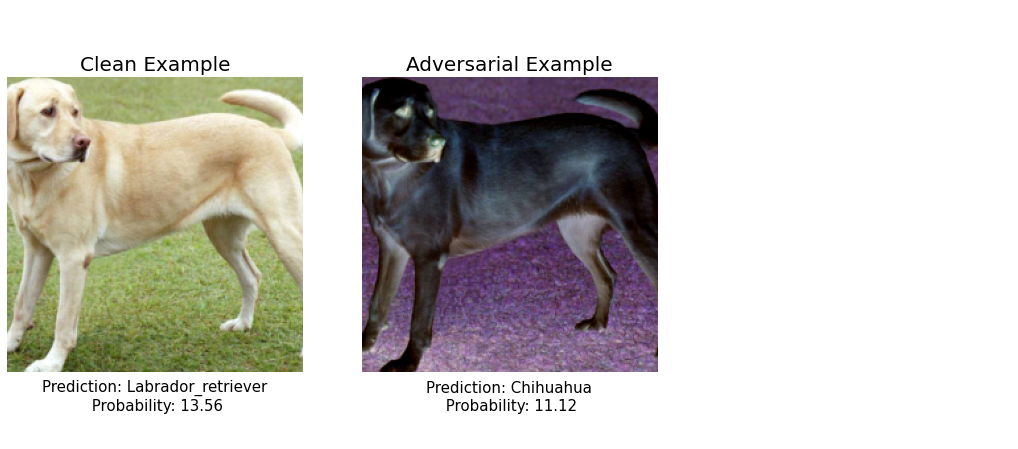

Sementic Attack: Success!


True

In [ ]:
test_semantic_attack('https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

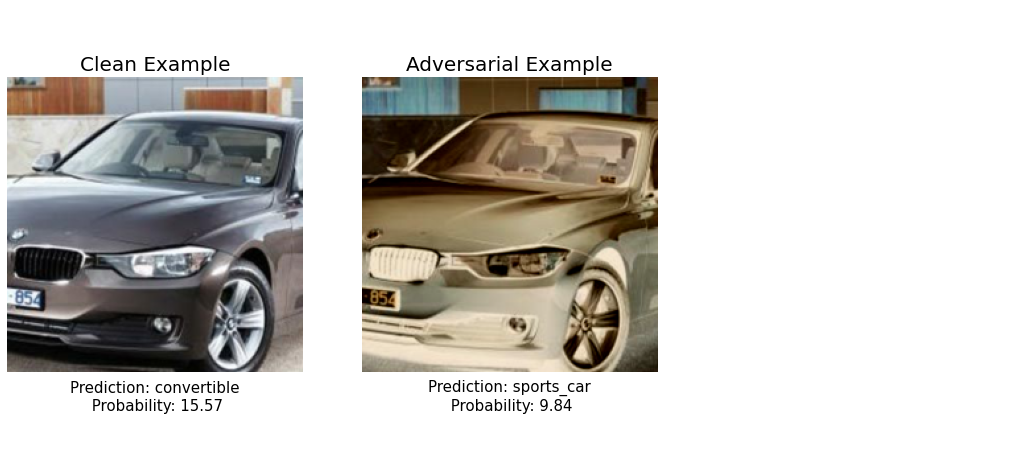

Sementic Attack: Success!


True

In [ ]:
test_semantic_attack('https://ai.stanford.edu/~jkrause/cars/car1.jpg')

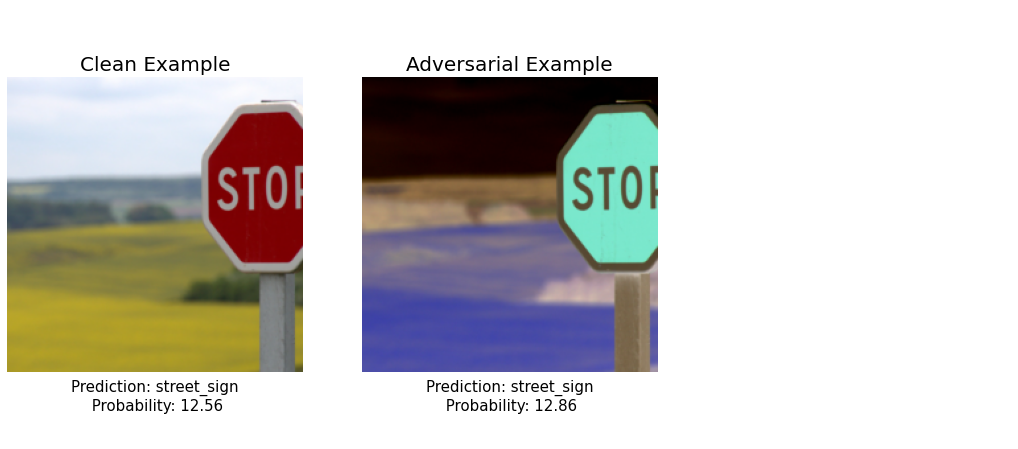

Sementic Attack: Fail...


False

In [ ]:
test_semantic_attack('https://miro.medium.com/max/3840/1*NcqhsFhED_W9OnyI0ZO3jA.jpeg')

Now let's test the attack method on your data and calculate the success rate:

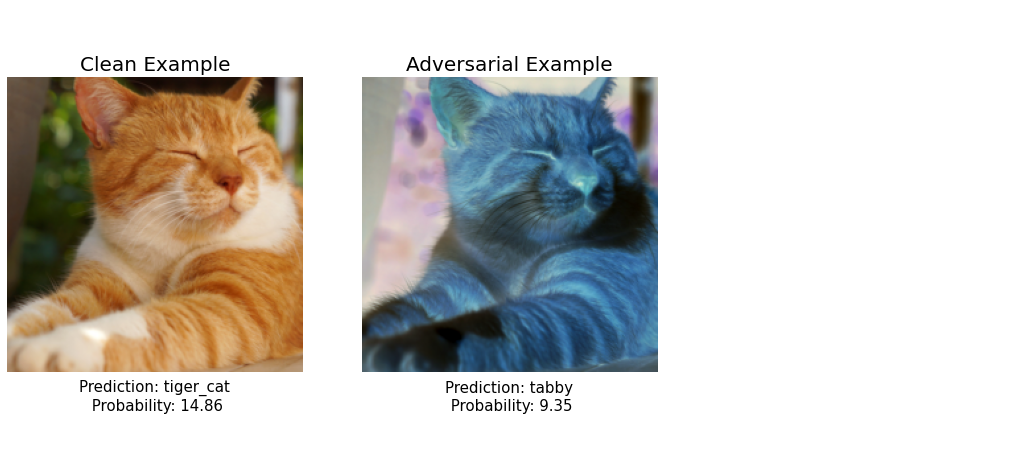

Sementic Attack: Success!


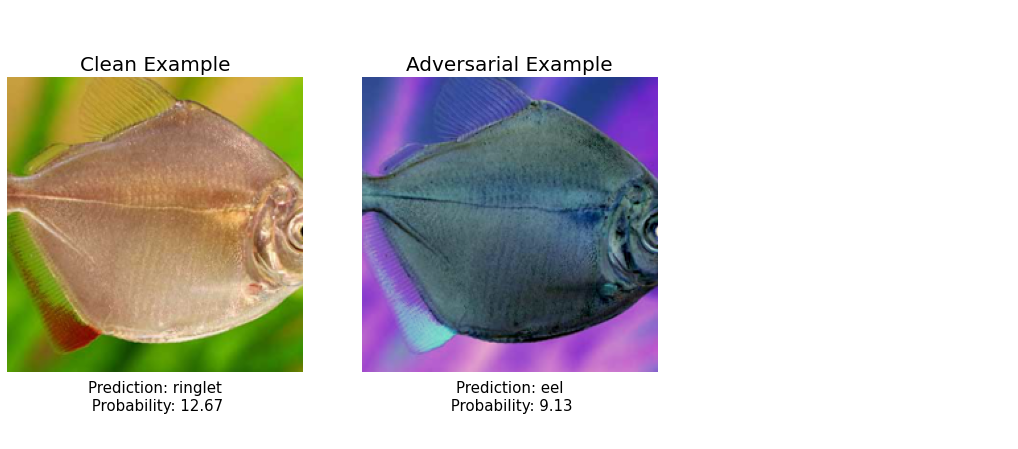

Sementic Attack: Success!


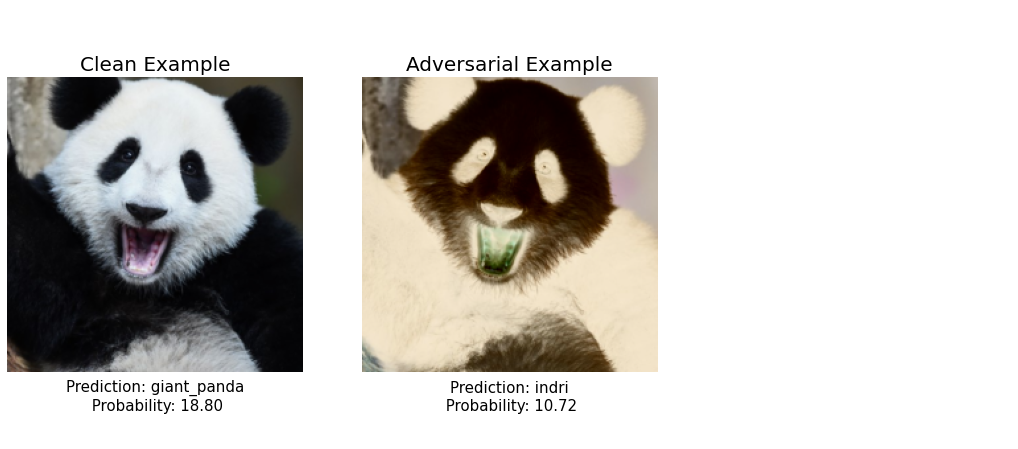

Sementic Attack: Success!


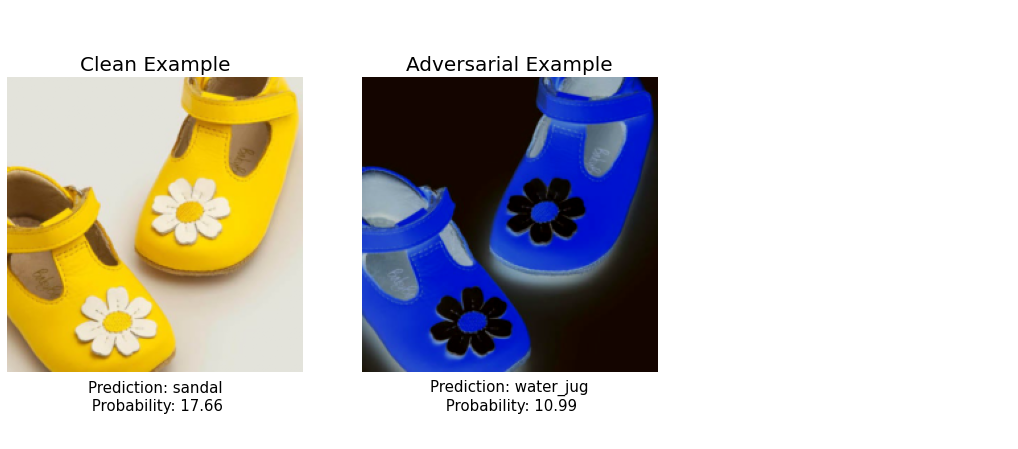

Sementic Attack: Success!
Success rate: 100.0%


In [ ]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += test_semantic_attack(img)

# Print the success_rate
print('Success rate: {:.1f}%'.format(100*success_rate/len(test_images)))

### Noise Attack

Noise is meaningless numbers put together, such that there is really no object present inside it. It is a random arrangement of pixels containing no information. In torch, we create this “noise” by using the [torch.randn()](https://pytorch.org/docs/master/generated/torch.randn.html) function, which returns a tensor filled with random numbers from a normal distribution (with mean 0 and standard deviation 1).

Noise is weak attack that just picks a random point in the attacker's action space. When combined with an attack bundling function, this can be used to implement random search.

References:
* https://arxiv.org/abs/1802.00420 recommends random search to help identify gradient masking 
* https://openreview.net/forum?id=H1g0piA9tQ recommends using noise as part of an attack building recipe combining many different optimizers to yield a strong optimizer.

In [ ]:
def noise_attack(x, epsilon=0.7):
  """
  input: 
    x:  torch.Tensor - tensor image
    epsilon: float - epsilon value in range [0; 1]. The larger the epsilon,
         the more noticeable the perturbations.
  return: 
    x_adv: torch.Tensor - perturbed image, the adversarial example
  """

  ## YOUR CODE HERE ##
  # Create the tensor noise by torch.randn() with the same shape of x and multiply by the epsilon (1 line)
  noise = torch.randn(x.shape) * epsilon

  # Generate the perturbed image x_adv by adding the noise to x (1 line)
  x_adv = x + noise

  ## END YOUR CODE HERE ##
  
  return x_adv

Assumed that the model can always correctly classify the clean images. Write the test function to test the attack method with a given image url and epsilon value:
* Read the image from the image url and classify it.
* Generate the adversarial image with the epsilon value and classfify it.
* Compare the predictions of the model and return whether the attack is successful or not.

In [ ]:
def test_noise_attack(img_url, epsilon=0.7):
  """
  Input:
    img_url: str - url of the image
  Return:
    bool: result of the attack:
        True: "Sucsess" - if the model is fooled by adversarial example,
        False: "Fail" - otherwise
  """
  # Get image tensor from url and preprocess
  x = load_and_preprocess(img_url)

  # Classify the clean image
  x_pred, x_pred_prob = classify(x)

  ## YOUR CODE HERE ##

  # Generate the adversarial image from the image tensor and epsilon (1 line)
  x_adv = noise_attack(x, epsilon)

  # Classify the adversarial image (1 line)
  x_adv_pred, x_adv_pred_prob = classify(x_adv)

  # Visualize the clean image, adversarial image and model predictions (1 line)
  visualize(x=(x, x_pred, x_pred_prob), 
            x_adv=(x_adv, x_adv_pred, x_adv_pred_prob))
  
  ## END YOUR CODE HERE ##

  # Compare the model predictions and return the result message
  if x_pred!= x_adv_pred:
    print('Noise Attack: Success!')
    return True
  print('Noise Attack: Fail...')
  return False

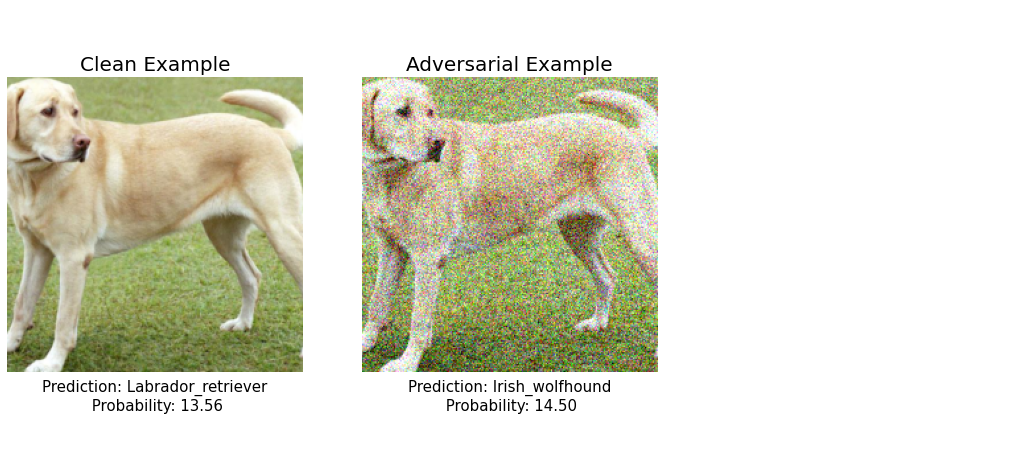

Noise Attack: Success!


True

In [ ]:
test_noise_attack('https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

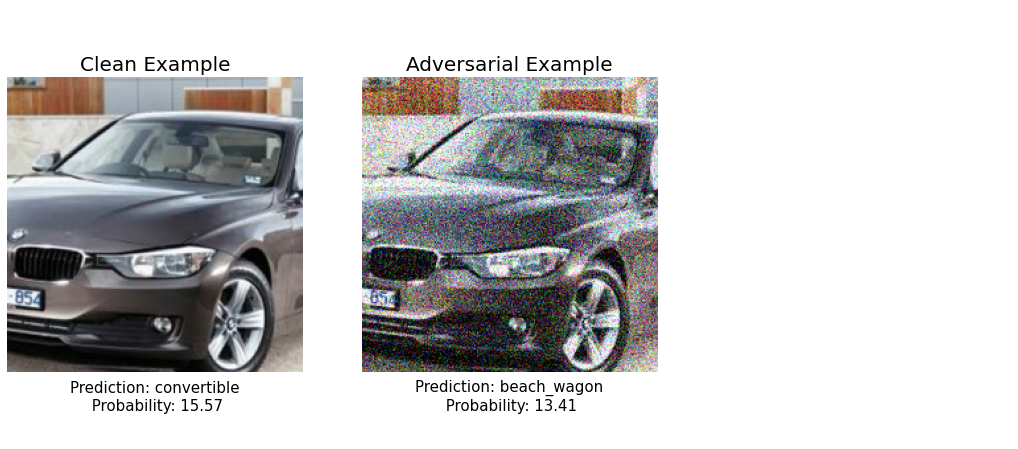

Noise Attack: Success!


True

In [ ]:
test_noise_attack('https://ai.stanford.edu/~jkrause/cars/car1.jpg', epsilon=0.75)

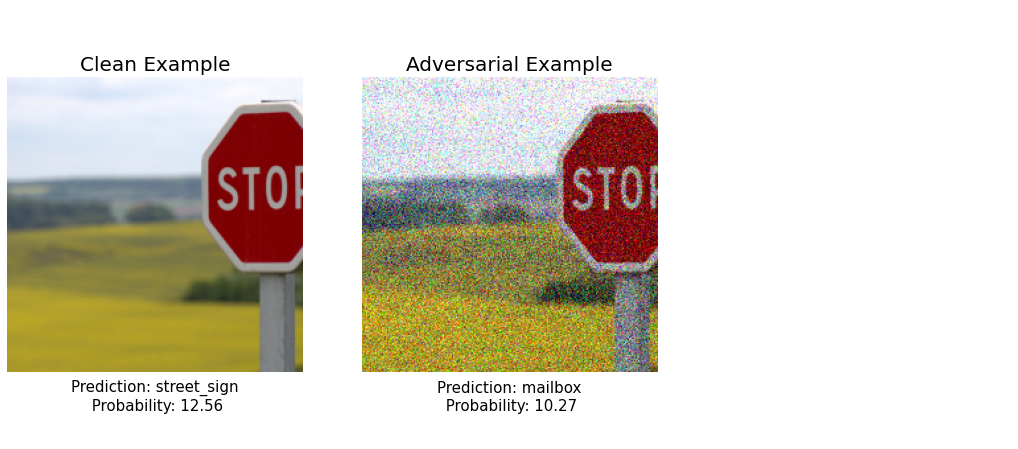

Noise Attack: Success!


True

In [ ]:
test_noise_attack('https://miro.medium.com/max/3840/1*NcqhsFhED_W9OnyI0ZO3jA.jpeg')

Now let's test the attack method on your data and calculate the success rate:

In [ ]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += test_noise_attack(img)

# Print the success_rate
print('Success rate: {:.1f}%'.format(100*success_rate/len(test_images)))

Output hidden; open in https://colab.research.google.com to view.

You can see that the success rate is not high since noise attack, or black-box attack in general, is weak. However, this simple method is the basic idea for many other adversarial attack methods. Let's take a look at more advanced attack methods in Activity 2.

## Task 2: Implement white-box attack methods

* Implement **FGSM Attack** 
* Implement **FGVM Attack** based on FGSM Attack
* Test the attack methods with your data from Activity 1

### FGSM Attack

One of the first and most popular adversarial attacks to date is referred to as the Fast Gradient Sign Method (FGSM) and is described by Goodfellow et. al. in Explaining and Harnessing Adversarial Examples. The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, gradients. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

The formula to find adversarial example is as follows:
$$ X^{adv} = X + \epsilon sign(\nabla_X J(X, Y_{true})$$
Here, <br>
X = original (clean) input <br>
$ X_{adv}$ = adversarial input (intentionally designed to be misclassified by our model) <br>
$ \epsilon $ = epsilon, the magnitude of adversarial perturbation  <br>
$ \nabla_X J(X, Y_{true}) $ = gradient of loss function w.r.t to input (X)

Reference: https://arxiv.org/abs/1412.6572

In [ ]:
def fgsm_attack(x, epsilon, data_grad):
  """
  Input:
    x: torch.Tensor - tensor image
    epsilon: float - epsilon value in range [0; 1]. The larger the epsilon,
         the more noticeable the perturbations.
    data_grad: torch.Tensor - data gradient
  Return:
    x_adv: torch.Tensor - tensor image of the adversarial example
  """
  ## YOUR CODE HERE ##
  # Calculate the sign of data gradient (1 line)
  sign_data_grad = data_grad.sign()
  
  # Create the perturbation by multiplying the gradient sign and epsilon (1 line)
  perturbation = epsilon*sign_data_grad

  # Generate the perturbed image by adding the perturbation (1 line)
  x_adv = x + perturbation

  ## END YOUR CODE HERE ##

  return x_adv

Assumed that the model can always correctly classify the clean images. Write the test function to test the attack method with different values of epsilon.

In [ ]:
def test_fgsm_attack(img_url, epsilon=0.01):
  """
  Input:
    img_url: str - url of the image
    epsilon: float or [float], epsilon value(s)
  Return:
    float: success rate, result of the attack.
          1 means the model is 100% fooled by adversarial example
  """
  # Get image tensor from url and preprocess
  x = load_and_preprocess(img_url)

  # Require calculating the gradient of the variable - important for attack
  x.requires_grad = True 
  
  # Forward pass the data through the model
  output = NET(x)
  
  # Get the predicted label with highest probability
  x_pred_prob, y_true = output.max(1, keepdim=True)
  x_pred_prob = x_pred_prob.item()
  y_true = y_true.item()
  x_pred = LABELS[y_true]
  target = torch.LongTensor([y_true])
  target.requires_grad = False

  # Calculate the loss
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, target)

  # Backward pass the data to get gradients
  loss_cal.backward(retain_graph=True)

  # Collect data gradient of image
  x_grad = x.grad.data

  success = 0

  # Perform attack with different epsilons
  if not isinstance(epsilon, list):
    epsilon = [epsilon]
  for eps in epsilon:
    # Generate the adversarial image and re-classify
    x_adv = fgsm_attack(x=x.data, epsilon=eps, data_grad=x_grad)
    output_adv = NET(x_adv)
    x_adv_pred_prob, x_adv_pred = output_adv.max(1, keepdim=True)
    x_adv_pred_prob = x_adv_pred_prob.item()
    x_adv_pred = x_adv_pred.item()
    x_adv_pred = LABELS[x_adv_pred]

    # Compare the results to count the success cases
    if x_pred!= x_adv_pred:
      success += 1

    # Visualize the clean image, adversarial image and model predictions
    visualize(x=(x.data, x_pred, x_pred_prob), perturb=(x_grad.sign(), eps),
              x_adv=(x_adv, x_adv_pred, x_adv_pred_prob))

  success_rate = success/len(epsilon)
  if success_rate > 0:
    print('FGSM Attack: {:.1f}% Success!'.format(100*success_rate))
  else:
    print('FGSM Attack: Fail...')
  return success_rate  

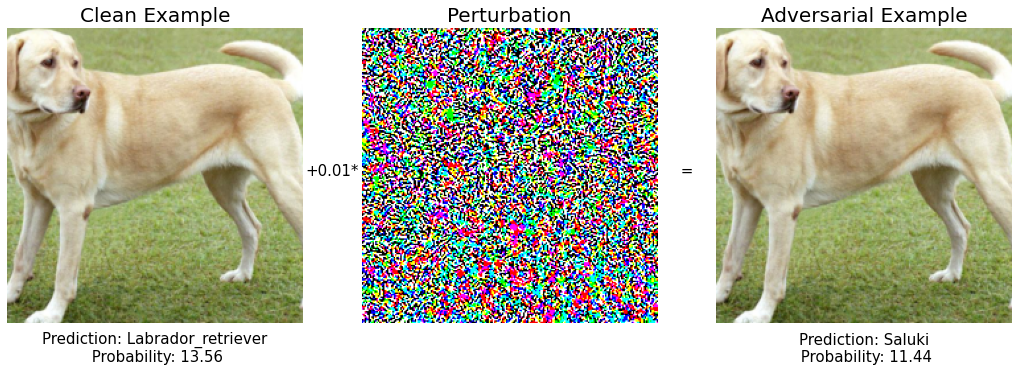

FGSM Attack: 100.0% Success!


1.0

In [ ]:
img_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
test_fgsm_attack(img_url)

<p style="font-size:18px; font-family:open sans; line-height:1.2">As you can see, the generated adversarial image is visually indistinguishable from the original image but the model classifies it as Saluki. Here is an example of a Saluki dog.

![Saluki dog](https://newcastlebeach.org/images/saluki.jpg)

Now, let us generate several adversarial images with different values of epsilon. Notice that as we increase the value of epsilon the adversarial image becomes distinguishable from the original one.

In [ ]:
test_fgsm_attack(img_url, epsilon=[0.0001, 0.004, 0.01, 0.3, 0.5])

Output hidden; open in https://colab.research.google.com to view.

<p style="font-size:18px; font-family:open sans; line-height:1.2">For very small value of epsilon, class doesn't change. But it decreases the probability. An alternative way is to use raw gradient (not sign) without any constraint (epsilon). It is called as Fast Gradient Value Method.

Now let's test the attack method with your data and calculate the success rate:

In [ ]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += test_fgsm_attack(img)

# Print the success_rate
print('Success rate: {:.1f}%'.format(100*success_rate/len(test_images)))

Output hidden; open in https://colab.research.google.com to view.

### FGVM Attack

Fast Gradient Value method is similar to FGSM but it replaces the sign of the gradient with the raw gradient: η = ∇xJ(θ, x, l). **Fast Gradient Value
method has no constraints (epsilon) on each pixel and can generate images with a larger local difference.**

The formula to find adversarial example is as follows:
$$ X^{adv} = X + \nabla_X J(X, Y_{true})$$
Here, <br>
X = original (clean) input <br>
$ X_{adv}$ = adversarial input (intentionally designed to be misclassified by our model) <br>
$ \nabla_X J(X, Y_{true}) $ = gradient of loss function w.r.t to input (X)

In [ ]:
def fgvm_attack(x, data_grad):
  """
  Input:
    x: torch.Tensor - tensor image
    data_grad: torch.Tensor - data gradient
  Return:
    x_adv: torch.Tensor - tensor image of the adversarial example
  """
  ## YOUR CODE HERE ##

  # Generate the perturbed image by adding the data grient value (1 line)
  x_adv = x + data_grad

  ## END YOUR CODE HERE ##
  return x_adv

Assumed that the model can always correctly classify the clean images. Write the test function to test the attack method, which is similar to FGSM but without epsilon.

In [ ]:
def test_fgvm_attack(img_url):
  """
  Input:
    img_url: str - url of the image
  Return:
    bool: result of the attack:
        True: "Sucsess" - if the model is fooled by adversarial example,
        False: "Fail" - otherwise

  The steps are similar to the test_fgsm_attack but: 
    (1) use the data gradient value instead of its signs to create the perturbation
    (2) there is no epsilon 
  """

  ## YOUR CODE HERE ##

  # Get image tensor from url and preprocess
  x = load_and_preprocess(img_url)

  # Require calculating the gradient of the variable - important for attack
  x.requires_grad = True 

  # Forward pass the data through the model
  output = NET(x)
  
  # Get the predicted label with highest probability
  x_pred_prob, y_true = output.max(1, keepdim=True)
  x_pred_prob = x_pred_prob.item()
  y_true = y_true.item()
  x_pred = LABELS[y_true]
  target = torch.LongTensor([y_true])
  target.requires_grad = False

  # Calculate the loss
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, target)

  # Backward pass the data to get gradients
  loss_cal.backward(retain_graph=True)

  # Collect data gradient of image
  x_grad = x.grad.data

  # Generate the adversarial image and re-classify
  x_adv = fgvm_attack(x=x.data, data_grad=x_grad)
  output_adv = NET(x_adv)
  x_adv_pred_prob, x_adv_pred = output_adv.max(1, keepdim=True)
  x_adv_pred_prob = x_adv_pred_prob.item()
  x_adv_pred = x_adv_pred.item()
  x_adv_pred = LABELS[x_adv_pred]

  # Visualize the clean image, adversarial image and model predictions
  visualize(x=(x.data, x_pred, x_pred_prob), perturb=(x_grad, 1),
            x_adv=(x_adv, x_adv_pred, x_adv_pred_prob))

  if x_pred!= x_adv_pred:
    print('FGVM Attack: Success!')
    return True
  print('FGVM Attack: Fail...')
  return False  

  ## END YOUR CODE HERE ##


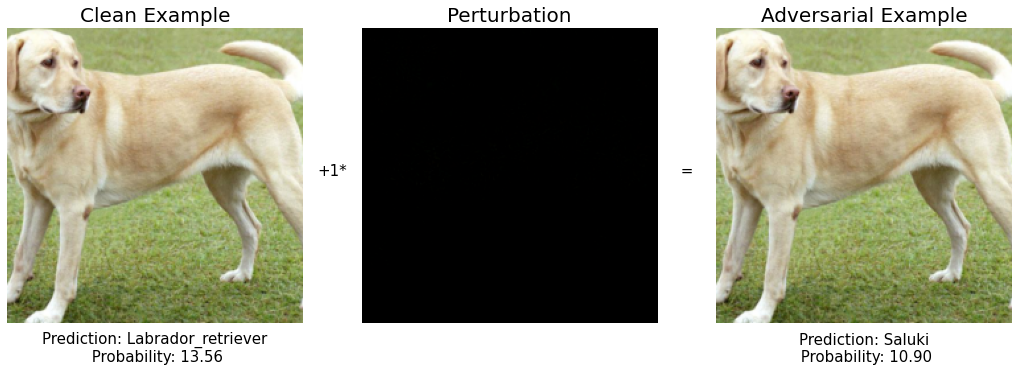

FGVM Attack: Success!


True

In [ ]:
test_fgvm_attack(img_url)

Now let's test the attack method on your data and calculate the success rate:

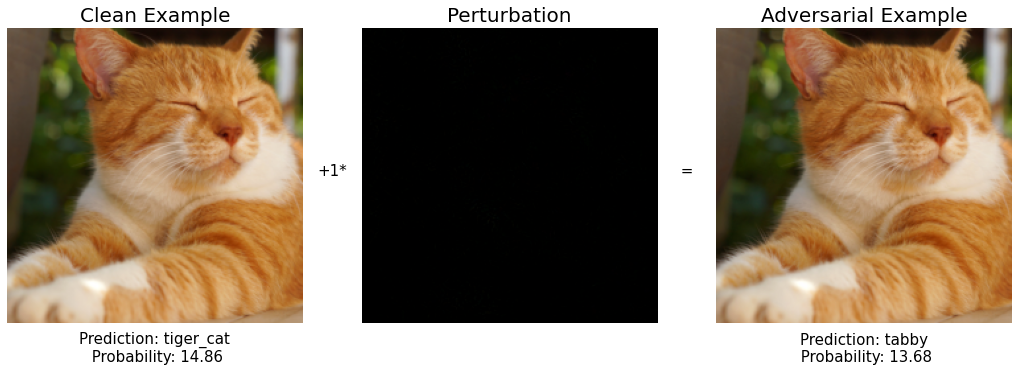

FGVM Attack: Success!


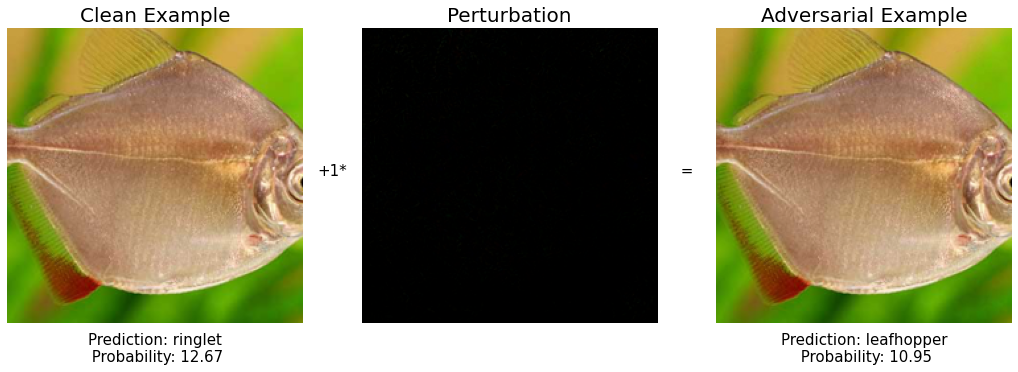

FGVM Attack: Success!


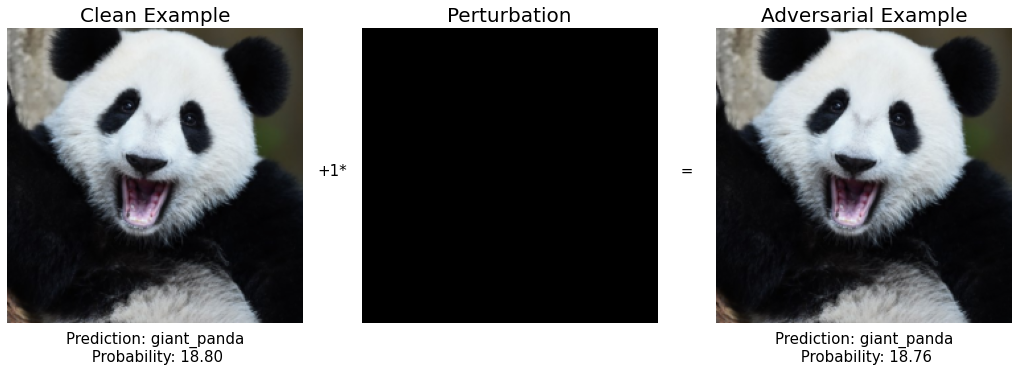

FGVM Attack: Fail...


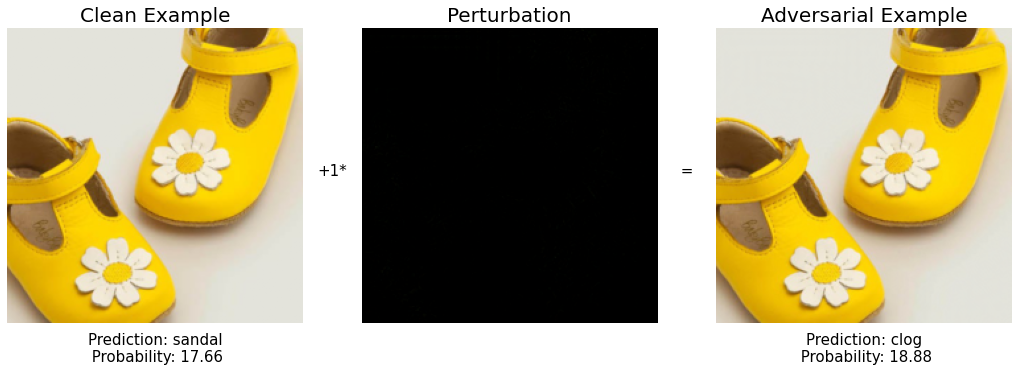

FGVM Attack: Success!
Success rate: 75.0


In [ ]:
## YOUR CODE HERE ##

# Run the test attack on your data test_images and calculate the success_rate
success_rate = 0
for img in test_images:
  success_rate += test_fgvm_attack(img)

# Print the success_rate
print('Success rate: {:.1f}'.format(100*success_rate/len(test_images)))

## What's next?

Now you understand the basic ideas and steps to generate the adversarial samples to attack the model. Let's try to evaluate the effectiveness of those attack methods on a model by generating adversarial data from a whole dataset and performing the attack. 

Reference: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html